<a href="https://colab.research.google.com/github/lorrespz/Image-Classification-Collection/blob/main/LSTM_for_image_classification_%5BFashionMNIST%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for image classification [FashionMNIST]

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load FashionMNIST from torchvision

In [2]:
train_set = torchvision.datasets.MNIST(root = '.', train = True,
                                       transform = transforms.ToTensor(), download = True)

test_set = torchvision.datasets.MNIST(root = '.', train = False,
                                       transform = transforms.ToTensor(), download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 74105775.15it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 85729436.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35800986.65it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21972928.22it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
bs= 128
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = bs, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = bs, shuffle = False)

# Build the RNN/LSTM model

In [4]:

class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs, device):
    super(RNN,self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(input_size = self.D,
                       hidden_size = self.M,
                       num_layers = self.L,
                       batch_first = True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    #initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    #get LSTM unit output:
    out, _ = self.rnn(X, (h0,c0))

    #we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])

    return out

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
# Input data is NxTxD, here T = 28, D = 28
model = RNN(28, 128, 2, 10, device = device )
model.to(device)

RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

# Train model

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [8]:

def full_gd(model, criterion, optimizer,  epochs):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)
      # reshape the input
      inputs = inputs.view(-1, 28, 28)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_loader:

      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 28, 28)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  return train_losses, test_losses

In [9]:
train_losses, test_losses = full_gd(model, criterion, optimizer, epochs = 10)

Epoch 1/10, Train Loss: 0.5572, Test Loss: 0.1807
Epoch 2/10, Train Loss: 0.1428, Test Loss: 0.1017
Epoch 3/10, Train Loss: 0.0958, Test Loss: 0.0864
Epoch 4/10, Train Loss: 0.0676, Test Loss: 0.0620
Epoch 5/10, Train Loss: 0.0555, Test Loss: 0.0627
Epoch 6/10, Train Loss: 0.0464, Test Loss: 0.0555
Epoch 7/10, Train Loss: 0.0397, Test Loss: 0.0539
Epoch 8/10, Train Loss: 0.0339, Test Loss: 0.0516
Epoch 9/10, Train Loss: 0.0322, Test Loss: 0.0588
Epoch 10/10, Train Loss: 0.0274, Test Loss: 0.0458


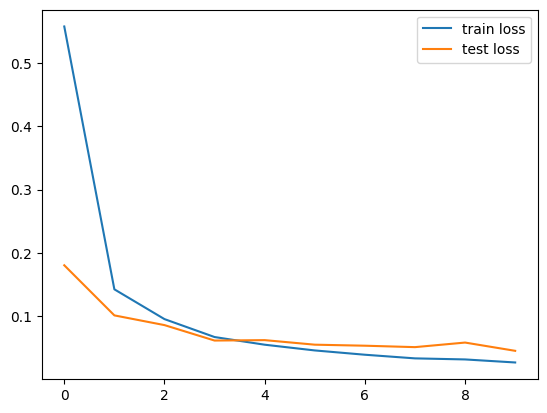

In [10]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# Calculate accuracy

In [11]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9935, Test acc: 0.9868


# Plot confusion matrix

In [12]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Do these results make sense?
# It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc.

Confusion matrix, without normalization
[[ 976    0    0    0    1    0    1    1    1    0]
 [   2 1129    0    1    0    0    2    1    0    0]
 [   3    1 1012    5    2    0    1    2    6    0]
 [   0    0    3  996    0    4    0    4    3    0]
 [   0    0    0    0  972    0    4    1    0    5]
 [   1    0    1    5    0  877    4    1    1    2]
 [   2    2    1    0    3    3  947    0    0    0]
 [   1    2    8    1    1    0    0 1013    0    2]
 [   3    0    0    5    2    1    0    3  960    0]
 [   0    0    0    2   15    1    1    3    1  986]]


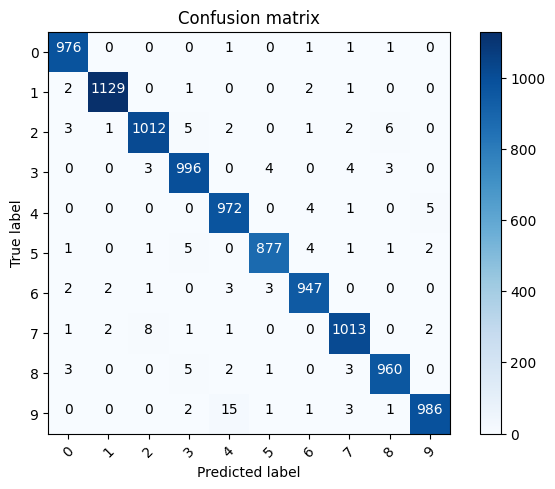

In [13]:
# get all predictions in an array and plot confusion matrix

x_test = test_set.data.numpy()
y_test = test_set.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))